In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])


In [ ]:

root_dir = './data'  
train_dataset_full = datasets.CIFAR10(root=root_dir, train=True, download=True, transform=transform)
test_dataset_full = datasets.CIFAR10(root=root_dir, train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:

class_indices = [0, 1, 2] 
selected_classes = [train_dataset_full.classes[i] for i in class_indices]

def filter_by_class(dataset, classes):
    indices = []
    for i, (_, label) in enumerate(dataset):
        if label in classes:
            indices.append(i)
    subset = torch.utils.data.Subset(dataset, indices)
    return subset

train_dataset_filtered = filter_by_class(train_dataset_full, class_indices)
test_dataset_filtered = filter_by_class(test_dataset_full, class_indices)


In [ ]:

num_train = int(0.8 * len(train_dataset_filtered))
num_val = len(train_dataset_filtered) - num_train

train_dataset, val_dataset = random_split(train_dataset_filtered, [num_train, num_val])


In [ ]:

batch_size = 64  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_filtered, batch_size=batch_size, shuffle=False)


Training Dataset:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.4039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67058825..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7490196..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the vali

Validation Dataset:


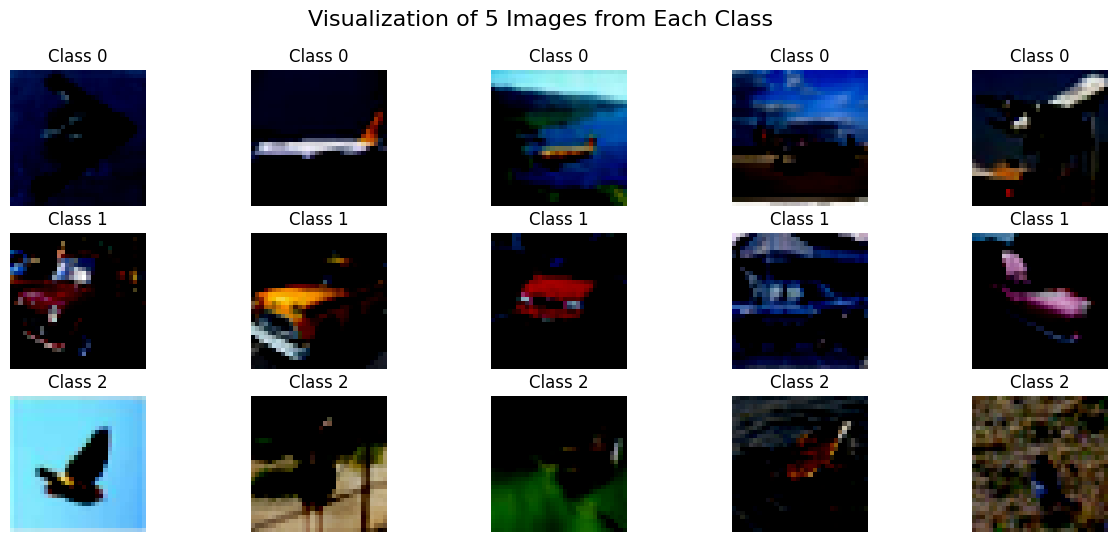

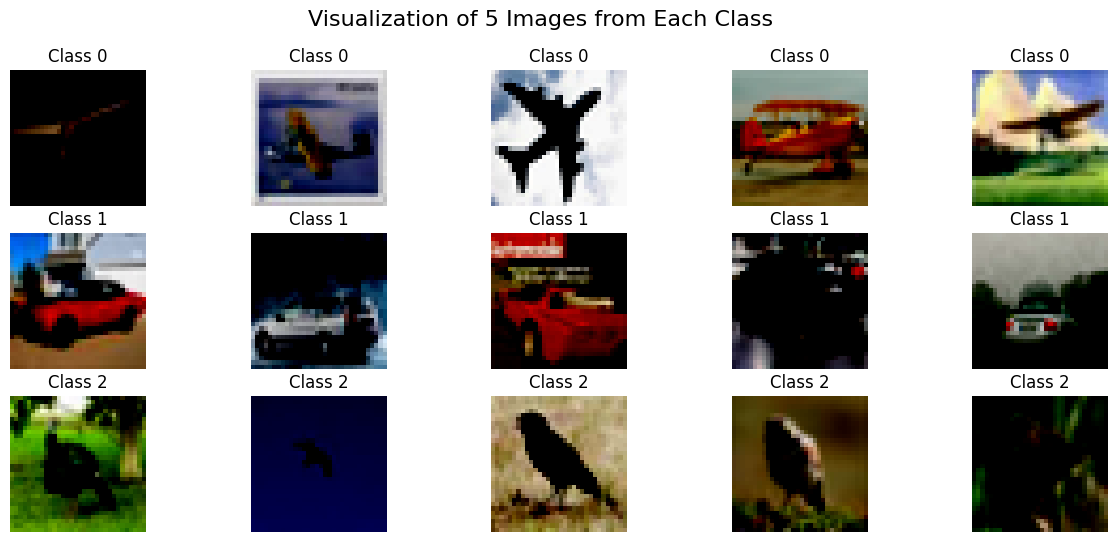

In [ ]:

def visualize_images(dataset, num_images=5, classes=[0, 1, 2]):
    fig, axes = plt.subplots(len(classes), num_images, figsize=(15, 6))
    fig.suptitle("Visualization of 5 Images from Each Class", fontsize=16)

    for i, cls in enumerate(classes):
        count = 0
        for img, label in dataset:
            if label == cls and count < num_images:
                axes[i, count].imshow(np.transpose(img.numpy(), (1, 2, 0)))
                axes[i, count].axis('off')
                axes[i, count].set_title(f"Class {cls}")
                count += 1
            if count >= num_images:
                break
print("Training Dataset:")
visualize_images(train_dataset, num_images=5)

print("Validation Dataset:")
visualize_images(val_dataset, num_images=5)
plt.show()


In [ ]:
# CNN 
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 16)    
        self.fc2 = nn.Linear(16, num_classes)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = 3 
model = CustomCNN(num_classes=num_classes)

print(model)


CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)


In [ ]:

device = torch.device('cpu')
print(f"Using device: {device}")

model = CustomCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):

    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

torch.save(model.state_dict(), "cnn_model.pth")
print("Model saved as cnn_model.pth")


Using device: cpu
Epoch 1/15, Train Loss: 0.7192, Train Acc: 67.80%, Val Loss: 0.5523, Val Acc: 78.23%
Epoch 2/15, Train Loss: 0.5044, Train Acc: 80.10%, Val Loss: 0.5212, Val Acc: 78.87%
Epoch 3/15, Train Loss: 0.4487, Train Acc: 82.22%, Val Loss: 0.4308, Val Acc: 83.20%
Epoch 4/15, Train Loss: 0.4027, Train Acc: 84.14%, Val Loss: 0.3931, Val Acc: 84.73%
Epoch 5/15, Train Loss: 0.3743, Train Acc: 85.34%, Val Loss: 0.4073, Val Acc: 84.07%
Epoch 6/15, Train Loss: 0.3606, Train Acc: 86.12%, Val Loss: 0.3690, Val Acc: 85.73%
Epoch 7/15, Train Loss: 0.3377, Train Acc: 86.79%, Val Loss: 0.3558, Val Acc: 86.20%
Epoch 8/15, Train Loss: 0.3207, Train Acc: 87.60%, Val Loss: 0.3288, Val Acc: 87.73%
Epoch 9/15, Train Loss: 0.3056, Train Acc: 88.41%, Val Loss: 0.3639, Val Acc: 86.07%
Epoch 10/15, Train Loss: 0.2976, Train Acc: 88.51%, Val Loss: 0.3390, Val Acc: 87.00%
Epoch 11/15, Train Loss: 0.2836, Train Acc: 88.97%, Val Loss: 0.3231, Val Acc: 87.83%
Epoch 12/15, Train Loss: 0.2736, Train Acc: 8

Train Accuracy: 0.9187, F1-score: 0.9186
Validation Accuracy: 0.8810, F1-score: 0.8809
Test Accuracy: 0.8857, F1-score: 0.8854


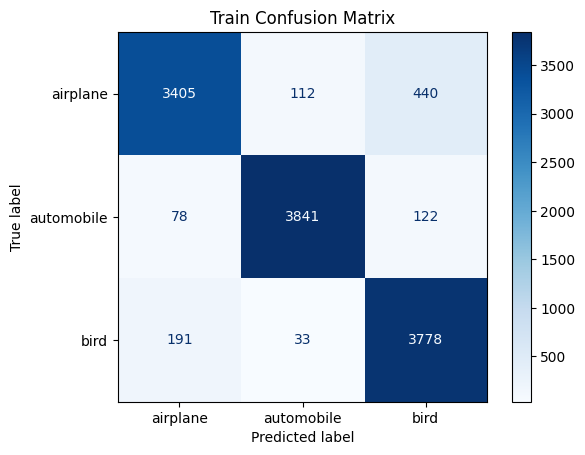

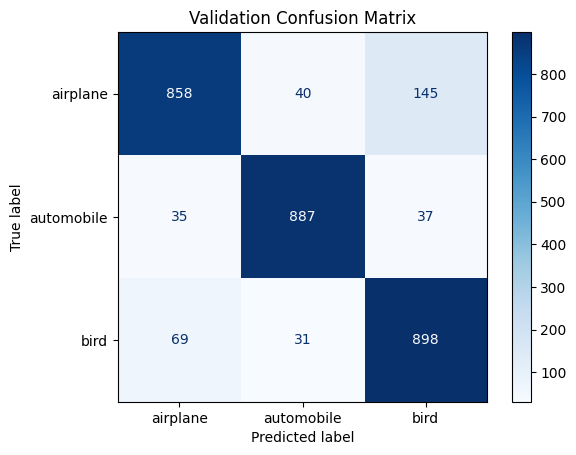

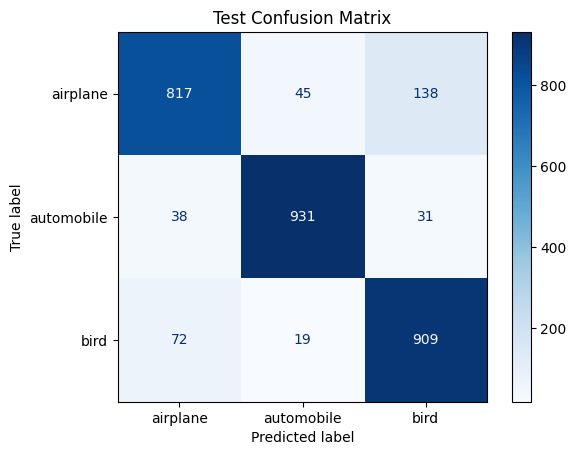

In [ ]:

def evaluate_model(loader, dataset_type):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"{dataset_type} Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
    return all_preds, all_labels

train_preds, train_labels = evaluate_model(train_loader, "Train")
val_preds, val_labels = evaluate_model(val_loader, "Validation")
test_preds, test_labels = evaluate_model(test_loader, "Test")

def plot_confusion_matrix(labels, preds, dataset_type):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
    disp.plot(cmap='Blues')
    plt.title(f"{dataset_type} Confusion Matrix")
    plt.show()

plot_confusion_matrix(train_labels, train_preds, "Train")
plot_confusion_matrix(val_labels, val_preds, "Validation")
plot_confusion_matrix(test_labels, test_preds, "Test")


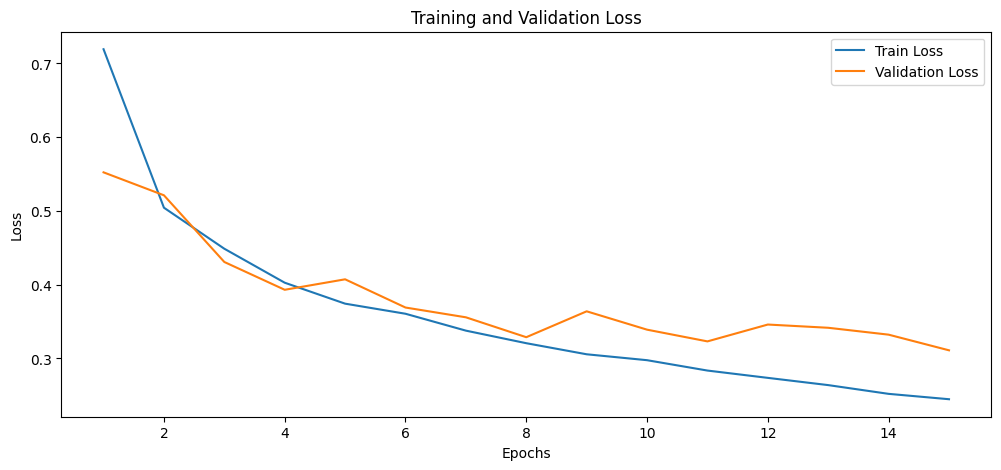

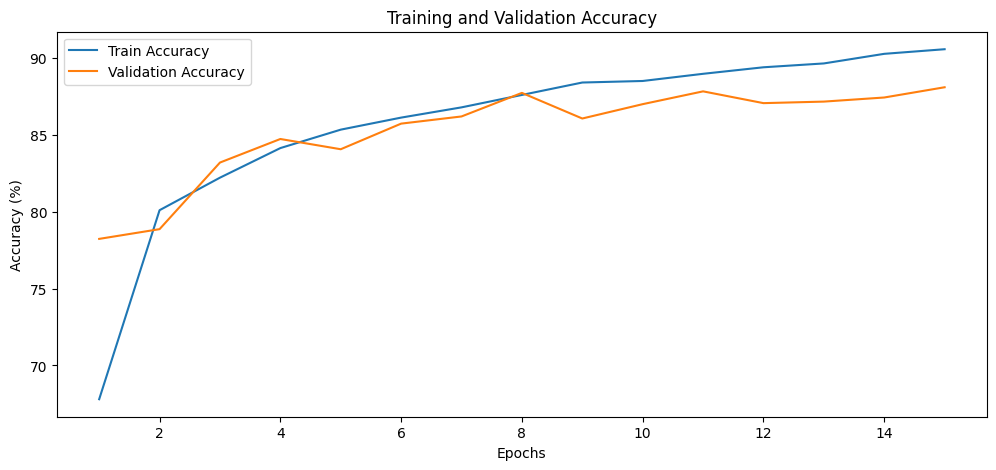

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
#MLP
class MLP(nn.Module):
    def __init__(self, num_classes=3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 64)  
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x))  
        x = self.fc2(x)          
        return x

model_mlp = MLP(num_classes=num_classes).to(device)

print(model_mlp)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)


MLP(
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:

num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    
    model_mlp.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_mlp(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    model_mlp.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_mlp(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

torch.save(model_mlp.state_dict(), "mlp_model.pth")
print("MLP Model saved as mlp_model.pth")

Epoch 1/15, Train Loss: 0.6935, Train Acc: 71.67%, Val Loss: 0.6010, Val Acc: 75.60%
Epoch 2/15, Train Loss: 0.5716, Train Acc: 77.59%, Val Loss: 0.5861, Val Acc: 76.47%
Epoch 3/15, Train Loss: 0.5127, Train Acc: 79.89%, Val Loss: 0.5603, Val Acc: 77.73%
Epoch 4/15, Train Loss: 0.4812, Train Acc: 81.19%, Val Loss: 0.5584, Val Acc: 78.77%
Epoch 5/15, Train Loss: 0.4310, Train Acc: 83.55%, Val Loss: 0.5588, Val Acc: 77.53%
Epoch 6/15, Train Loss: 0.4028, Train Acc: 84.61%, Val Loss: 0.5528, Val Acc: 78.47%
Epoch 7/15, Train Loss: 0.3777, Train Acc: 85.70%, Val Loss: 0.5614, Val Acc: 79.27%
Epoch 8/15, Train Loss: 0.3572, Train Acc: 86.53%, Val Loss: 0.5643, Val Acc: 79.20%
Epoch 9/15, Train Loss: 0.3227, Train Acc: 87.90%, Val Loss: 0.5921, Val Acc: 78.40%
Epoch 10/15, Train Loss: 0.2958, Train Acc: 89.39%, Val Loss: 0.5890, Val Acc: 79.37%
Epoch 11/15, Train Loss: 0.2787, Train Acc: 89.51%, Val Loss: 0.6003, Val Acc: 78.70%
Epoch 12/15, Train Loss: 0.2595, Train Acc: 90.58%, Val Loss: 0

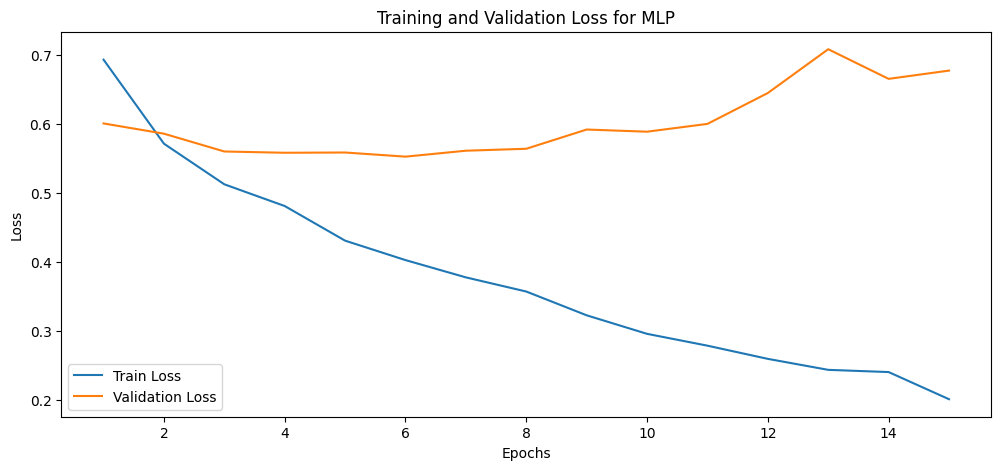

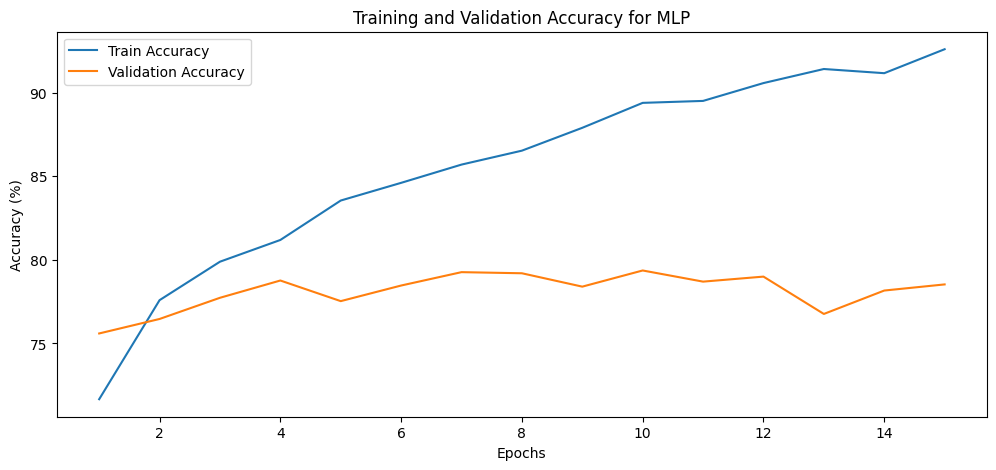

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for MLP")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy for MLP")
plt.legend()
plt.show()


Train Dataset - Accuracy: 93.49%, F1-Score: 0.9352


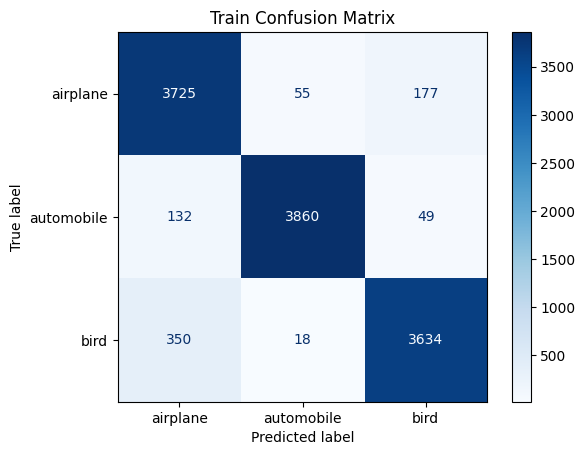

Validation Dataset - Accuracy: 78.53%, F1-Score: 0.7859


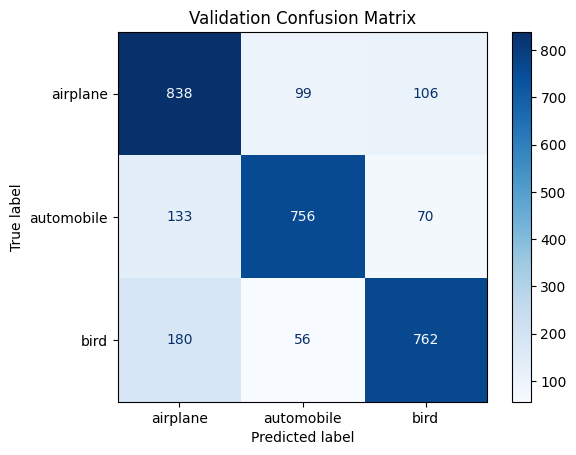

Test Dataset - Accuracy: 80.47%, F1-Score: 0.8054


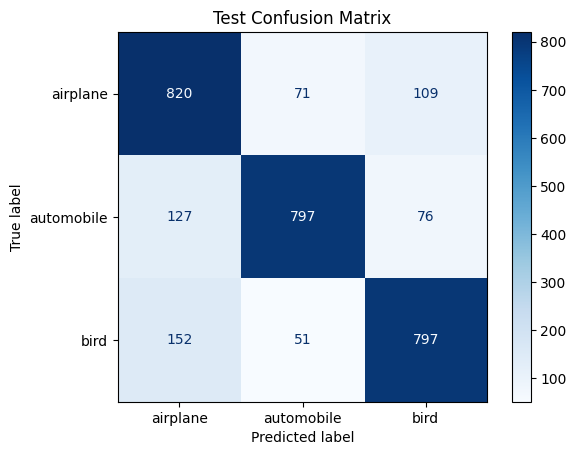

In [ ]:


def evaluate_and_plot(loader, dataset_name, model, selected_classes):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"{dataset_name} Dataset - Accuracy: {accuracy:.2f}%, F1-Score: {f1:.4f}")
    
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
    disp.plot(cmap='Blues')
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

selected_classes = ['airplane', 'automobile', 'bird'] 

evaluate_and_plot(train_loader, "Train", model_mlp, selected_classes)
evaluate_and_plot(val_loader, "Validation", model_mlp, selected_classes)
evaluate_and_plot(test_loader, "Test", model_mlp, selected_classes)
